# Air Quality Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

print('Pandas version:', pd.__version__) # 2.2.3
print('Numpy version:', np.__version__) # 1.26.4
print('Seaborn version:', sns.__version__) # 0.13.2

Pandas version: 2.2.3
Numpy version: 1.26.4
Seaborn version: 0.13.2


## Loading the dataset

In [2]:
df = pd.read_csv('./data/combined_data.csv')
df

,Date,Latitude,Longitude,PM1,PM2.5,PM10,NO2,Sensor_ID
0,2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,I30
1,2021-01-02,NaN,NaN,NaN,NaN,NaN,NaN,I30
2,2021-01-03,NaN,NaN,NaN,NaN,NaN,NaN,I30
3,2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,I30
4,2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN,I30
...,...,...,...,...,...,...,...,...
9970,2024-11-15,"51,4136","5,4707","6,25","8,90","16,15",17.0,I17
9971,2024-11-16,"51,4136","5,4707","10,48","11,76","16,36",17.0,I17
9972,2024-11-17,"51,4136","5,4707","14,02","15,73","21,29",5.0,I17
9973,2024-11-18,"51,4136","5,4707","5,81","7,56","13,27",5.0,I17


First let's start with getting a general idea of the dataset. We have a few different columns in our dataset:
* Latitude & Longitude: these are the coordinates of the sensor.
* PM1: extremely fine particulates with a diameter of fewer than 1 microns.
* PM2.5: fine particles with a diameter of less than 2.5 microns.
* PM10: particles with a diameter of less than 10 microns (100 times smaller than a millimeter).
* NO<sub>2</sub>: nitrogen dioxide.
* Sensor ID: the id of the sensor that has collected the data.

#### What do these PM values mean?
PM is short for particulate matter, it's a range of particles of dust, dirt and liquids that become suspended in the air. Some particles are large enough to see, like smoke or smog, but most are invisible. Particulate matter is categorised by size, which means that PM10 includes all particles with a size of less than 10 μg. This means it also includes particles that are already included in PM2.5, therefore the PM10 will always be higher than PM2.5, and PM2.5 will always be higher than PM1. (https://www.airthings.com/resources/pm-size-difference)

These particles are harmful for health. By analysing the data and correlating it with the temperature data we will research how much of an effect these particles have on the temperature.

## Analysing the Dataset
When we loaded the dataframe we can see that the dataset also contains data from 2024. Since this year is not complete yet we do not want to include it in our model, so we will limit the data to 31-12-2023.

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] <= '2023-12-31']
df.tail()

,Date,Latitude,Longitude,PM1,PM2.5,PM10,NO2,Sensor_ID
9644,2023-12-27,"51,4136","5,4707","4,63","7,23","14,38",14.0,I17
9645,2023-12-28,"51,4136","5,4707","3,87","6,00","13,03",14.0,I17
9646,2023-12-29,"51,4136","5,4707","4,55","7,62","15,29",4.0,I17
9647,2023-12-30,"51,4136","5,4707","3,19","5,53","11,52",4.0,I17
9648,2023-12-31,"51,4136","5,4707","4,12","6,93","14,24",5.0,I17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7693 entries, 0 to 9648
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7693 non-null   datetime64[ns]
 1   Latitude   7403 non-null   object        
 2   Longitude  7403 non-null   object        
 3   PM1        7413 non-null   object        
 4   PM2.5      7413 non-null   object        
 5   PM10       7413 non-null   object        
 6   NO2        5808 non-null   float64       
 7   Sensor_ID  7693 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 540.9+ KB


We can see the values of the particulate matters are listed as objects and not as a float. First we will convert these to float, so we can analyse the statistics.

In [5]:
df.loc[:, ['PM1', 'PM2.5', 'PM10']] = df.loc[:, ['PM1', 'PM2.5', 'PM10']].replace(',', '.', regex=True)
df.loc[:, ['PM1', 'PM2.5', 'PM10']] = df.loc[:, ['PM1', 'PM2.5', 'PM10']].apply(pd.to_numeric, errors='coerce')

print(df.dtypes)


Date         datetime64[ns]
Latitude             object
Longitude            object
PM1                  object
PM2.5                object
PM10                 object
NO2                 float64
Sensor_ID            object
dtype: object


We can also see some columns contain null values. Let's further investigate these null values.

In [6]:
def calculate_missing_values(group):
    return {
        'Total Rows': group.shape[0],
        'Missing Latitude': group['Latitude'].isnull().sum(),
        'Missing Longitude': group['Longitude'].isnull().sum(),
        'Missing PM1': group['PM1'].isnull().sum(),
        'Missing PM2.5': group['PM2.5'].isnull().sum(),
        'Missing PM10': group['PM10'].isnull().sum(),
        'Missing NO2': group['NO2'].isnull().sum(),
        'Total Missing Cells': group.isnull().sum().sum(),
        'Missing Cell Percentage (%)': round((group.isnull().sum().sum() / (group.shape[0] * group.shape[1])) * 100, 2),
    }

def get_missing_values_summary(df, group_by_col):
    missing_values = df.groupby(group_by_col).apply(calculate_missing_values, include_groups=False)

    df_missing_values = pd.DataFrame.from_records(missing_values.values, index=missing_values.index)

    df_missing_values.columns = [
        'Total Rows', 'Missing Latitude', 'Missing Longitude', 
        'Missing PM1', 'Missing PM2.5', 'Missing PM10', 'Missing NO2',
        'Total Missing Cells', 'Missing Cell Percentage (%)'
    ]

    df_missing_values = df_missing_values.sort_values(by='Missing Cell Percentage (%)', ascending=False)
    df_missing_values = df_missing_values.reset_index()
    df_missing_values = df_missing_values.rename(columns={'index': group_by_col})

    return df_missing_values

df_missing_values = get_missing_values_summary(df, 'Sensor_ID')
df_missing_values

,Sensor_ID,Total Rows,Missing Latitude,Missing Longitude,Missing PM1,Missing PM2.5,Missing PM10,Missing NO2,Total Missing Cells,Missing Cell Percentage (%)
0,I17,1099,90,90,90,90,90,317,767,9.97
1,I36,1099,80,80,48,48,48,275,579,7.53
2,I30,1099,28,28,84,84,84,236,544,7.07
3,I12,1099,38,38,38,38,38,265,455,5.91
4,I37,1099,22,22,0,0,0,318,362,4.71
5,I07,1099,14,14,11,11,11,238,299,3.89
6,I19,1099,18,18,9,9,9,236,299,3.89


By looking at this summary of the missing values we can see NO<sub>2</sub> has the most missing values. We can also see sensor I17 has the most missing values compared to the other sensors. Almost 10% of all cells are missing.

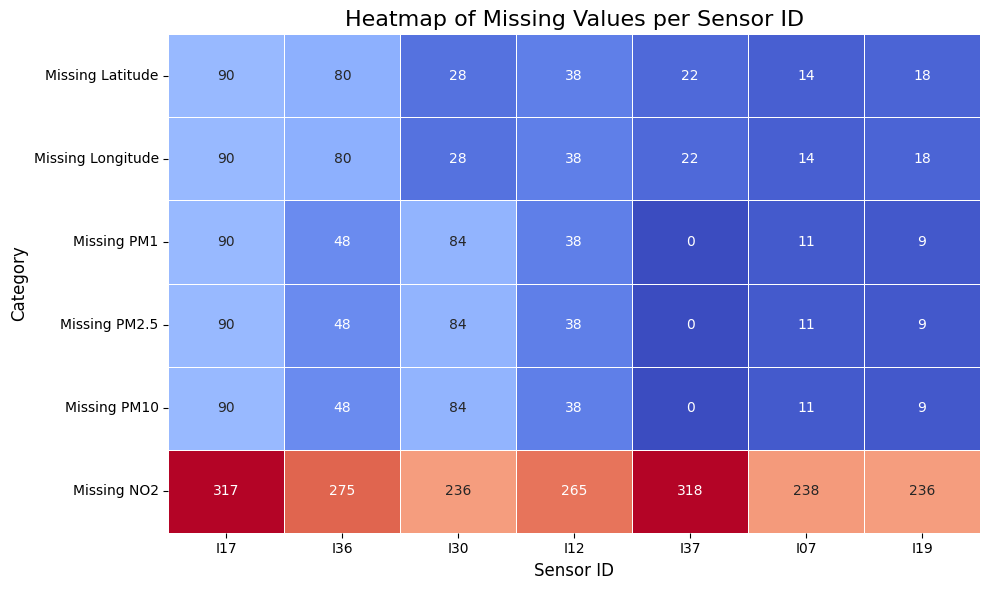

In [7]:
heatmap = df_missing_values.set_index('Sensor_ID')[
    ['Missing Latitude', 'Missing Longitude', 'Missing PM1', 'Missing PM2.5', 'Missing PM10', 'Missing NO2']
]

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap.transpose(),
    annot=True,
    fmt="d",
    cmap="coolwarm",
    linewidths=0.5,
    cbar=False
)
plt.title('Heatmap of Missing Values per Sensor ID', fontsize=16)
plt.xlabel('Sensor ID', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()


Next we will look at the missing values grouped by the date and the sensor, so we can see what days the sensors were not working and remove those rows from the dataframe. Since the latitude and longitude should be the same value for the sensor, these can be easily filled in and should not be included when calculating 100% of the missing values.

In [8]:
def calculate_fully_missing(group):
    relevant_columns = group.loc[:, ~group.columns.isin(['Sensor_ID', 'Date', 'Latitude', 'Longitude'])]
    
    total_cells = relevant_columns.shape[0] * relevant_columns.shape[1]
    total_missing = relevant_columns.isnull().sum().sum()
    missing_percentage = round((total_missing / total_cells) * 100, 2) if total_cells > 0 else 0
    
    summary = relevant_columns.isnull().sum().to_dict()
    summary.update({
        'Total Missing Cells': total_missing,
        'Missing Cell Percentage (%)': missing_percentage
    })
    return pd.Series(summary)

df_missing_values_per_date = (
    df.groupby(['Sensor_ID', 'Date'])
    .apply(calculate_fully_missing, include_groups=False)
    .reset_index()
)

df_missing_values_per_date = df_missing_values_per_date[
    df_missing_values_per_date['Total Missing Cells'] > 0
].reset_index(drop=True)

df_missing_values_per_date.head(15)


,Sensor_ID,Date,PM1,PM2.5,PM10,NO2,Total Missing Cells,Missing Cell Percentage (%)
0,I07,2021-01-01,1.0,1.0,1.0,1.0,4.0,100.0
1,I07,2021-01-02,1.0,1.0,1.0,1.0,4.0,100.0
2,I07,2021-01-03,1.0,1.0,1.0,1.0,4.0,100.0
3,I07,2021-01-04,1.0,1.0,1.0,1.0,4.0,100.0
4,I07,2021-01-05,1.0,1.0,1.0,1.0,4.0,100.0
5,I07,2021-01-06,1.0,1.0,1.0,1.0,4.0,100.0
6,I07,2021-01-07,1.0,1.0,1.0,1.0,4.0,100.0
7,I07,2021-01-08,1.0,1.0,1.0,1.0,4.0,100.0
8,I07,2021-01-09,1.0,1.0,1.0,1.0,4.0,100.0
9,I07,2021-01-10,1.0,1.0,1.0,1.0,4.0,100.0


In [9]:
import plotly.express as px

fig = px.line(
    df_missing_values_per_date, 
    x='Date', 
    y='Missing Cell Percentage (%)', 
    color='Sensor_ID', 
    markers=True, 
    title='Interactive Missing Data Trends',
    labels={'Missing Cell Percentage (%)': 'Missing %'}
)
fig.show()


In this plot we can see the percentage of values missing per sensor in a timeline. We can see for sensor I07 a lot of days contain missing values between Januari 2021 and Januari 2022, however for most days only 25% is missing, which is only 1 value. We can also see 100% of the values missing for some values.

What is strange is that on 01-01-2023 37,5% seems to be missing for sensor I30, however there are only 4 values that can be missing so it has to be either 25% or 50%.

In [10]:
df_20230101 = df[(df['Date'] == '2023-01-01') & (df['Sensor_ID'] == 'I30')]
df_20230101

,Date,Latitude,Longitude,PM1,PM2.5,PM10,NO2,Sensor_ID
732,2023-01-01,"51,4375","5,4516",NaN,NaN,NaN,19.0,I30
733,2023-01-01,"51,4375","5,4516",4.6,7.44,19.23,8.0,I30


By looking at this date we can see two records for the same sensor on 01-01-2023. We only want one value per date so let's check if more dates contain multiple values.

In [11]:
duplicate_rows = df.groupby(['Sensor_ID', 'Date']).size().reset_index(name='Counts')
duplicate_rows = duplicate_rows[duplicate_rows['Counts'] > 1]
duplicate_rows = duplicate_rows.sort_values(by=['Sensor_ID', 'Date']).reset_index(drop=True)

duplicate_rows


,Sensor_ID,Date,Counts
0,I07,2022-01-01,2
1,I07,2022-01-02,2
2,I07,2023-01-01,2
3,I07,2023-01-02,2
4,I12,2022-01-01,2
5,I12,2022-01-02,2
6,I12,2023-01-01,2
7,I12,2023-01-02,2
8,I17,2022-01-01,2
9,I17,2022-01-02,2


We can see that all sensors contain duplicate values for the dates 01-01-2022/02-01-2022 and 01-01-2023/02-01-2023. I feel like there might be a problem with the end and the beginning of the year.

In [12]:
num_sensors = df['Sensor_ID'].nunique() # 7
total_days_spanned = df['Date'].dt.date.nunique() # 1095

total_dates = num_sensors * total_days_spanned
print("Total possible dates:", total_dates)

print("Total number of rows:", len(df))
print(f"Difference: {len(df) - total_dates }")

Total possible dates: 7665
Total number of rows: 7693
Difference: 28


Here we can see that there is a difference of 28 days, this is most likely because of the duplicate days. I am not gonna look at all these days individually but will remove the entries that contain the most amount of missing values, and if they both contain the same amount of missing values I will keep the first entry.

In [13]:
def calculate_missing_count(row):
    return row.isnull().sum()

df.loc[:, 'missing_count'] = df[['PM1', 'PM2.5', 'PM10', 'NO2', 'Latitude', 'Longitude']].apply(calculate_missing_count, axis=1)
df_sorted = df.sort_values(by=['Sensor_ID', 'Date', 'missing_count'], ascending=[True, True, True])
df_cleaned_duplicates = df_sorted.drop_duplicates(subset=['Sensor_ID', 'Date'], keep='first')
df_cleaned_duplicates = df_cleaned_duplicates.drop(columns=['missing_count'])
df_cleaned_duplicates.head()

num_sensors = df_cleaned_duplicates['Sensor_ID'].nunique() # 7
total_days_spanned = df_cleaned_duplicates['Date'].dt.date.nunique() # 1095

total_dates = num_sensors * total_days_spanned
print("Total possible dates:", total_dates)

print("Total number of rows:", len(df_cleaned_duplicates))
print(f"Difference: {len(df_cleaned_duplicates) - total_dates }")


Total possible dates: 7665
Total number of rows: 7665
Difference: 0


/var/folders/qp/02j4_gk9273413dxs9s5_c4m0000gn/T/ipykernel_20427/406959786.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now we can see the total amount of rows in the dataframe corresponds with the total amount of dates. Let's continue with looking at the remaining missing values and recalculate the 100% missing values.

In [14]:
df_cleaned_duplicates_missing_values = (
    df_cleaned_duplicates.groupby(['Sensor_ID', 'Date'])
    .apply(calculate_fully_missing, include_groups=False)
    .reset_index()
)

df_cleaned_duplicates_missing_values = df_cleaned_duplicates_missing_values[df_cleaned_duplicates_missing_values['Total Missing Cells'] > 0].reset_index(drop=True)

df_cleaned_duplicates_missing_values.sample(5)

,Sensor_ID,Date,PM1,PM2.5,PM10,NO2,Total Missing Cells,Missing Cell Percentage (%)
1269,I30,2021-10-26,0.0,0.0,0.0,1.0,1.0,25.0
83,I07,2021-06-13,0.0,0.0,0.0,1.0,1.0,25.0
1417,I36,2021-05-25,0.0,0.0,0.0,1.0,1.0,25.0
622,I17,2021-07-20,0.0,0.0,0.0,1.0,1.0,25.0
1531,I36,2021-09-16,0.0,0.0,0.0,1.0,1.0,25.0


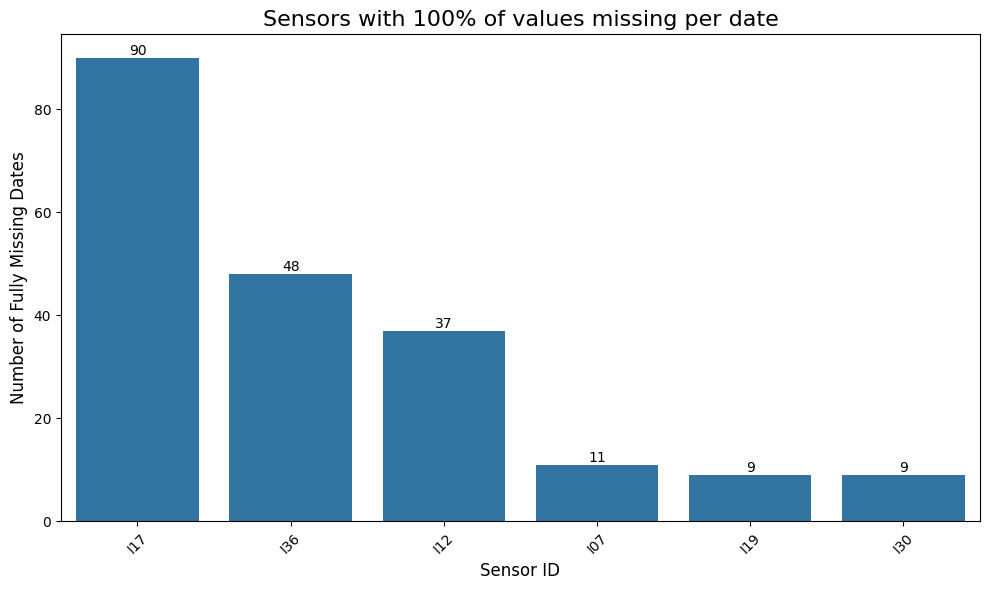

In [15]:
fully_missing_dates = df_cleaned_duplicates_missing_values[df_cleaned_duplicates_missing_values['Missing Cell Percentage (%)'] == 100]

missing_counts = fully_missing_dates.groupby('Sensor_ID').size().reset_index(name='Dates Fully Missing')
missing_counts = missing_counts.sort_values(by='Dates Fully Missing', ascending=False)

plt.figure(figsize=(10,6))
bar_plot = sns.barplot(
    data=missing_counts,
    x='Sensor_ID',
    y='Dates Fully Missing'
)

for bar, value in zip(bar_plot.patches, missing_counts['Dates Fully Missing']):
    bar_x = bar.get_x() + bar.get_width() / 2
    bar_height = bar.get_height()

    plt.text(
        x=bar_x, 
        y=bar_height, 
        s=f"{value}", 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black'
    )

plt.title('Sensors with 100% of values missing per date', fontsize=16)
plt.xlabel('Sensor ID', fontsize=12)
plt.ylabel('Number of Fully Missing Dates', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cleaning the data
We can conclude the sensors did not work these dates, so we will remove these rows from the dataframe.

In [16]:
df_cleaned = df_cleaned_duplicates.merge(
    fully_missing_dates[['Sensor_ID', 'Date']],
    on=['Sensor_ID', 'Date'],
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns=['_merge']).reset_index(drop=True)

df_cleaned.head()

,Date,Latitude,Longitude,PM1,PM2.5,PM10,NO2,Sensor_ID
0,2021-01-12,"51,4568","5,4383",12.57,14.43,18.98,7.0,I07
1,2021-01-13,"51,4568","5,4383",2.95,4.3,9.31,18.0,I07
2,2021-01-14,"51,4567","5,4382",7.14,9.92,19.15,35.0,I07
3,2021-01-15,"51,4567","5,4382",6.45,8.39,14.2,28.0,I07
4,2021-01-16,"51,4567","5,4382",15.0,16.44,20.35,31.0,I07


In [17]:
print(f"Original rows: {df_cleaned_duplicates.shape[0]}")
print(f"Fully missing rows: {fully_missing_dates.shape[0]}")
print(f"Cleaned rows: {df_cleaned.shape[0]}")

Original rows: 7665
Fully missing rows: 204
Cleaned rows: 7461


We can see the 204 rows that contained 100% missing values have been removed from the dataframe. Next we will look at the remaining missing values.

In [18]:
df_missing_values = get_missing_values_summary(df_cleaned, 'Sensor_ID')
df_missing_values

,Sensor_ID,Total Rows,Missing Latitude,Missing Longitude,Missing PM1,Missing PM2.5,Missing PM10,Missing NO2,Total Missing Cells,Missing Cell Percentage (%)
0,I30,1086,19,19,73,73,73,227,484,6.37
1,I37,1095,22,22,0,0,0,318,362,4.72
2,I36,1047,32,32,0,0,0,227,291,3.97
3,I17,1005,0,0,0,0,0,227,227,3.23
4,I19,1086,9,9,0,0,0,227,245,3.22
5,I07,1084,3,3,0,0,0,227,233,3.07
6,I12,1058,0,0,0,0,0,227,227,3.07


By looking at this dataframe we can see most missing PM values have been removed from the dataframe, except for sensor I30. Let's look at this sensor.

In [19]:
df_sensor_i30 = df_cleaned[df_cleaned['Sensor_ID'] == 'I30'].copy() 
df_sensor_i30_pm_missing = df_sensor_i30[['PM1', 'PM2.5', 'PM10']]

missing_pm_values = df_sensor_i30_pm_missing.isnull().sum(axis=1)

df_sensor_i30.loc[:, 'Missing_PM_Values'] = missing_pm_values 

df_sensor_i30_with_missing_pm = df_sensor_i30[df_sensor_i30['Missing_PM_Values'] > 0]

df_sensor_i30_with_missing_pm

,Date,Latitude,Longitude,PM1,PM2.5,PM10,NO2,Sensor_ID,Missing_PM_Values
4955,2023-01-02,"51,4375","5,4517",NaN,NaN,NaN,24.0,I30,3
4956,2023-01-03,"51,4375","5,4517",NaN,NaN,NaN,20.0,I30,3
4957,2023-01-04,"51,4375","5,4516",NaN,NaN,NaN,21.0,I30,3
4958,2023-01-05,"51,4374","5,4513",NaN,NaN,NaN,9.0,I30,3
4959,2023-01-06,"51,4374","5,4513",NaN,NaN,NaN,15.0,I30,3
...,...,...,...,...,...,...,...,...,...
5023,2023-03-11,"51,4375","5,4515",NaN,NaN,NaN,17.0,I30,3
5024,2023-03-12,"51,4374","5,4515",NaN,NaN,NaN,28.0,I30,3
5025,2023-03-13,"51,4375","5,4515",NaN,NaN,NaN,20.0,I30,3
5026,2023-03-14,"51,4374","5,4515",NaN,NaN,NaN,11.0,I30,3


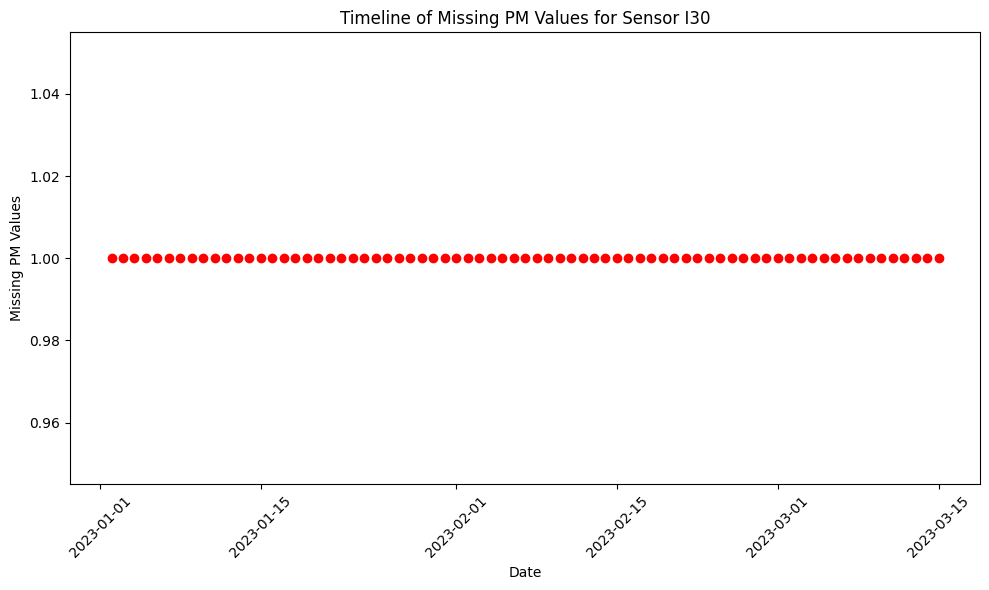

No gaps in missing PM values for Sensor I30.

Start Date of Missing PM Values: 2023-01-02 00:00:00
End Date of Missing PM Values: 2023-03-15 00:00:00


In [20]:
df_sensor_i30_with_missing_pm_sorted = df_sensor_i30_with_missing_pm.sort_values('Date')

missing_dates = df_sensor_i30_with_missing_pm_sorted['Date']

missing_dates_diff = missing_dates.diff()

plt.figure(figsize=(10, 6))
plt.plot(missing_dates, [1] * len(missing_dates), 'ro', label='Missing PM Values')
plt.title('Timeline of Missing PM Values for Sensor I30')
plt.xlabel('Date')
plt.ylabel('Missing PM Values')

# display the gaps in the timeline (if there are any)
for i, diff in enumerate(missing_dates_diff):
    if diff > pd.Timedelta(days=1):
        plt.axvline(missing_dates.iloc[i], color='blue', linestyle='--', label='Gap' if i == 0 else "")

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

gaps = missing_dates_diff[missing_dates_diff > pd.Timedelta(days=1)]
if not gaps.empty:
    print("Gaps in missing PM values on the following dates:")
    print(gaps)
else:
    print("No gaps in missing PM values for Sensor I30.")

start_date = missing_dates.min()
end_date = missing_dates.max()

print(f"\nStart Date of Missing PM Values: {start_date}")
print(f"End Date of Missing PM Values: {end_date}")

By looking at this plot we can see there are no PM values recorded for sensor I30 between 02-01-2023 and 15-03-2023, so the sensor was probably not working correctly during this time span. These are also the only missing PM values we have left in our dataframe.

### Filling in missing values
Finally we can start with filling in the missing values for the longitude and lattitude. Since these values should not differ as much per sensor, I am gonna fill them in with the value that is the most frequent per value.

In [21]:
def fill_missing_coordinates(df):
    mode_values = df.groupby('Sensor_ID')[['Latitude', 'Longitude']].apply(lambda group: group.mode().iloc[0])

    for sensor in df['Sensor_ID'].unique():
        mode_latitude = mode_values.loc[sensor, 'Latitude']
        mode_longitude = mode_values.loc[sensor, 'Longitude']
        
        df.loc[(df['Sensor_ID'] == sensor) & (df['Latitude'].isnull()), 'Latitude'] = mode_latitude
        df.loc[(df['Sensor_ID'] == sensor) & (df['Longitude'].isnull()), 'Longitude'] = mode_longitude
        
    return df

df_cleaned = fill_missing_coordinates(df_cleaned)

print(df_cleaned[['Sensor_ID', 'Latitude', 'Longitude']].isnull().sum())
df_cleaned.head()

Sensor_ID    0
Latitude     0
Longitude    0
dtype: int64


,Date,Latitude,Longitude,PM1,PM2.5,PM10,NO2,Sensor_ID
0,2021-01-12,"51,4568","5,4383",12.57,14.43,18.98,7.0,I07
1,2021-01-13,"51,4568","5,4383",2.95,4.3,9.31,18.0,I07
2,2021-01-14,"51,4567","5,4382",7.14,9.92,19.15,35.0,I07
3,2021-01-15,"51,4567","5,4382",6.45,8.39,14.2,28.0,I07
4,2021-01-16,"51,4567","5,4382",15.0,16.44,20.35,31.0,I07


In [22]:
df_missing_values = get_missing_values_summary(df_cleaned, 'Sensor_ID')
df_missing_values

,Sensor_ID,Total Rows,Missing Latitude,Missing Longitude,Missing PM1,Missing PM2.5,Missing PM10,Missing NO2,Total Missing Cells,Missing Cell Percentage (%)
0,I30,1086,0,0,73,73,73,227,446,5.87
1,I37,1095,0,0,0,0,0,318,318,4.15
2,I17,1005,0,0,0,0,0,227,227,3.23
3,I36,1047,0,0,0,0,0,227,227,3.10
4,I12,1058,0,0,0,0,0,227,227,3.07
5,I07,1084,0,0,0,0,0,227,227,2.99
6,I19,1086,0,0,0,0,0,227,227,2.99


## Export Dataframe

In [23]:
output_file = "data/cleaned_data.csv"

df_cleaned.to_csv(output_file, index=False)